In [155]:
import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme.expressions import Beta, Variable
from biogeme.models import loglogit, piecewise_formula, boxcox
from biogeme.segmentation import DiscreteSegmentationTuple, segmented_beta
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
# Loading the data
df = pd.read_csv('lpmc06.dat', sep='\t')

In [102]:
display(df.columns)

Index(['trip_id', 'household_id', 'person_n', 'trip_n', 'travel_mode',
       'purpose', 'fueltype', 'faretype', 'bus_scale', 'survey_year',
       'travel_year', 'travel_month', 'travel_date', 'day_of_week',
       'start_time', 'age', 'female', 'driving_license', 'car_ownership',
       'distance', 'dur_walking', 'dur_cycling', 'dur_pt_access',
       'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int', 'pt_interchanges',
       'dur_driving', 'cost_transit', 'cost_driving_fuel',
       'cost_driving_ccharge', 'driving_traffic_percent'],
      dtype='object')

In [103]:
display(df.head())

,trip_id,household_id,person_n,trip_n,travel_mode,purpose,fueltype,faretype,bus_scale,survey_year,...,dur_pt_access,dur_pt_rail,dur_pt_bus,dur_pt_int,pt_interchanges,dur_driving,cost_transit,cost_driving_fuel,cost_driving_ccharge,driving_traffic_percent
0,7,0,2,1,4,3,1,3,0.0,1,...,0.109444,0.000000,0.055556,0.000000,0,0.059444,0.0,0.15,0.0,0.112150
1,21,5,1,1,4,3,1,5,0.0,1,...,0.083889,0.000000,0.293611,0.000000,0,0.167778,0.0,0.46,0.0,0.243377
2,27,7,1,0,4,4,2,1,1.0,1,...,0.193889,0.516667,0.000000,0.100000,1,0.340833,1.5,2.04,0.0,0.280359
3,52,12,1,2,4,5,2,1,1.0,1,...,0.062500,0.000000,0.491944,0.094722,1,0.355556,3.0,1.19,0.0,0.249219
4,53,12,1,3,4,3,2,1,1.0,1,...,0.082500,0.000000,0.061944,0.000000,0,0.062500,1.5,0.17,0.0,0.124444


In [ ]:
df["dur_pt"] = df["dur_pt_access"] + df["dur_pt_rail"] + df["dur_pt_bus"] + df["dur_pt_int"]

In [105]:
database = db.Database('lpmc', df)

## Model 0

We identify the variables that will enter the model specification.

In [106]:
# Time related variables
dur_walking = Variable('dur_walking') # in hours
dur_cycling = Variable('dur_cycling') # in hours
dur_pt_access = Variable('dur_pt_access') # in hours
dur_pt_rail = Variable('dur_pt_rail') # in hours
dur_pt_bus = Variable('dur_pt_bus') # in hours
dur_pt_int = Variable('dur_pt_int') # in hours
dur_driving = Variable('dur_driving') # in hours

dur_pt = dur_pt_access + dur_pt_rail + dur_pt_bus + dur_pt_int

# Cost related variables
cost_transit = Variable('cost_transit') # in GBP
cost_driving_fuel = Variable('cost_driving_fuel') # in GBP
cost_driving_ccharge = Variable('cost_driving_ccharge') # in GBP

cost_driving = cost_driving_fuel + cost_driving_ccharge

# Choice taken by the individual
travel_mode = Variable('travel_mode') # 1 = walk, 2 = cycle, 3 = PT, 4 = car

Parameters to be estimated

In [107]:
# ASC_WALK = Beta('asc_walk', 0, None, None, 0)
ASC_CYCLE = Beta('asc_cycle', 0, None, None, 0)
ASC_PT = Beta('asc_pt', 0, None, None, 0)
ASC_CAR = Beta('asc_car', 0, None, None, 0)

B_TIME = Beta('b_time', 0, None, None, 0)
B_COST = Beta('b_cost', 0, None, None, 0)

Definition of the utility functions.

In [108]:
# Walk
V1 = (
  # ASC_WALK -> Normalized with respect to walk
  B_TIME * dur_walking
)

# Cycle
V2 = (
  ASC_CYCLE
  + B_TIME * dur_cycling
)

# Public transport
V3 = (
  ASC_PT
  + B_TIME * dur_pt
  #+ B_TIME * (dur_pt_access + dur_pt_rail + dur_pt_bus + dur_pt_int)
  + B_COST * cost_transit
)

# Car
V4 = (
  ASC_CAR
  + B_TIME * dur_driving
  + B_COST * cost_driving
  #+ B_COST * (cost_driving_fuel + cost_driving_ccharge)
)

In [109]:
V = {1: V1, 2: V2, 3: V3, 4: V4}

Definition of the model.

In [110]:
# All alternatives are available to all individuals.
logprob = loglogit(V, None, travel_mode)
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_0'

Estimate the parameters.

In [111]:
results = biogeme.estimate()

Summary statistics.

In [112]:
print(results.print_general_statistics())

Number of estimated parameters:	5
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4658.601
Final log likelihood:	-4658.601
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00107
Akaike Information Criterion:	9327.202
Bayesian Information Criterion:	9359.788
Final gradient norm:	1.0183E-03
Nbr of threads:	8



In [113]:
display(results.get_estimated_parameters())

,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_car,-1.264832,0.078562,-16.099815,0.0
asc_cycle,-3.742817,0.103011,-36.334033,0.0
asc_pt,-0.552210,0.053870,-10.250839,0.0
b_cost,-0.160728,0.014288,-11.248889,0.0
b_time,-5.340745,0.197809,-26.999514,0.0


## Model 1
In this version of the model, we introduce alternative-specific coefficients for either b_time (model 1a) or b_cost (model 1b), and we compare the results to determine which model yields the best results 

### Model 1a (alternative-specific b_time)


Parameters to be estimated

In [114]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_1A = Beta('ASC_CYCLE_1A', 0, None, None, 0)
ASC_PT_1A    = Beta('ASC_PT_1A', 0, None, None, 0)
ASC_CAR_1A   = Beta('ASC_CAR_1A', 0, None, None, 0)

# Alternative specific time coefficient
B_TIME_WALK_1A  = Beta('B_TIME_WALK_1A', 0, None, None, 0)
B_TIME_CYCLE_1A = Beta('B_TIME_CYCLE_1A', 0, None, None, 0)
B_TIME_PT_1A    = Beta('B_TIME_PT_1A', 0, None, None, 0)
B_TIME_CAR_1A   = Beta('B_TIME_CAR_1A', 0, None, None, 0)

# Generic cost coefficient
B_COST_1A = Beta('B_COST_1A', 0, None, None, 0)

Definition of the utility functions

In [115]:
V_walk_1A = (
    B_TIME_WALK_1A * dur_walking
)

V_cycle_1A = (
    ASC_CYCLE_1A
    + B_TIME_CYCLE_1A * dur_cycling
)

V_PT_1A = (
    ASC_PT_1A
    + B_TIME_PT_1A * dur_pt
    + B_COST_1A * cost_transit
)

V_car_1A = (
    ASC_CAR_1A
    + B_TIME_CAR_1A * dur_driving
    + B_COST_1A * cost_driving
)

V_1A = {1: V_walk_1A, 2: V_cycle_1A, 3: V_PT_1A, 4: V_car_1A}

Definition of the model

In [116]:
logprob_1A = loglogit(V_1A, None, travel_mode)
biogeme_1A = bio.BIOGEME(database, logprob_1A)
biogeme_1A.modelName = 'model_1A'

Estimation and display of the results

In [117]:
results_1A = biogeme_1A.estimate()
print(results_1A.print_general_statistics())

Number of estimated parameters:	8
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4319.913
Final log likelihood:	-4319.913
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00185
Akaike Information Criterion:	8655.826
Bayesian Information Criterion:	8707.963
Final gradient norm:	9.8655E-03
Nbr of threads:	8



In [118]:
display(results_1A.get_estimated_parameters())

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR_1A,-2.087661,0.133307,-15.660567,0.0
ASC_CYCLE_1A,-4.799358,0.193220,-24.838871,0.0
ASC_PT_1A,-2.552549,0.135051,-18.900568,0.0
B_COST_1A,-0.140590,0.015325,-9.174017,0.0
B_TIME_CAR_1A,-6.120530,0.405937,-15.077540,0.0
B_TIME_CYCLE_1A,-5.197150,0.467915,-11.107043,0.0
B_TIME_PT_1A,-3.256306,0.254676,-12.786051,0.0
B_TIME_WALK_1A,-8.643432,0.418678,-20.644602,0.0


_Observations for the report_

First, we observe that all the B coefficients are negative, which makes sense, because a longer and/or more expensive travel mode is less attractive. 

The cost coefficient of model 1A is very close to the one for the model 0. On the other hand, the time coefficient, which was made alternative specific in model 1A, now strongly depends on the chosen mode. In particular, we observe it is the smallest (in absolute value) for PT; an interpretation could be that commuters are more prone to long PT travel times because they can read, sleep, etc., activites they cannot do while driving or cycling. On the other hand, the largest time_coefficient (again, in absolute value) is for walking, probably because beyond 20-30 minutes, people consider that doing the route by foot is too long.

If we compare the Akaike or Bayesian information criterion between model 0 and model 1a, we observe they are both lower in the case of model 1a; it means the latter fits the data better than model 0.

### Model 1b (alternative-specific b_cost)

We reproduce exactly the same steps as for model 1A, but we now assume a generic time coefficient, and a alternative specific cost coefficient

Parameters to be estimated

In [119]:
# Alternative specific constants (ASC_walk is normalized to 0)
ASC_CYCLE_1B = Beta('ASC_CYCLE_1B', 0, None, None, 0)
ASC_PT_1B    = Beta('ASC_PT_1B', 0, None, None, 0)
ASC_CAR_1B   = Beta('ASC_CAR_1B', 0, None, None, 0)

# Alternative specific cost coefficient
B_COST_PT_1B    = Beta('B_COST_PT_1B', 0, None, None, 0)
B_COST_CAR_1B   = Beta('B_COST_CAR_1B', 0, None, None, 0)

# Generic time coefficient
B_TIME_1B = Beta('B_TIME_1B', 0, None, None, 0)

Definition of the utility functions 

In [120]:
V_walk_1B = (
    B_TIME_1B * dur_walking
)

V_cycle_1B = (
    ASC_CYCLE_1B
    + B_TIME_1B * dur_cycling
)

V_PT_1B = (
    ASC_PT_1B
    + B_TIME_1B * dur_pt
    + B_COST_PT_1B * cost_transit
)

V_car_1B = (
    ASC_CAR_1B
    + B_TIME_1B * dur_driving
    + B_COST_CAR_1B * cost_driving
)

V_1B = {1: V_walk_1B, 2: V_cycle_1B, 3: V_PT_1B, 4: V_car_1B}

Definition of the model

In [121]:
logprob_1B = loglogit(V_1B, None, travel_mode)
biogeme_1B = bio.BIOGEME(database, logprob_1B)
biogeme_1B.modelName = 'model_1B'

Estimation and display of the results

In [122]:
results_1B = biogeme_1B.estimate()
print(results_1B.print_general_statistics())

Number of estimated parameters:	6
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4607.516
Final log likelihood:	-4607.516
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.0013
Akaike Information Criterion:	9227.032
Bayesian Information Criterion:	9266.136
Final gradient norm:	5.3980E-04
Nbr of threads:	8



In [123]:
display(results_1B.get_estimated_parameters())

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR_1B,-1.181056,0.078388,-15.066824,0.000000
ASC_CYCLE_1B,-3.698346,0.103376,-35.775502,0.000000
ASC_PT_1B,-0.836648,0.065575,-12.758696,0.000000
B_COST_CAR_1B,-0.205583,0.021929,-9.374982,0.000000
B_COST_PT_1B,0.052828,0.029809,1.772231,0.076356
B_TIME_1B,-5.339547,0.200044,-26.691801,0.000000


In [124]:
lr_result1A = results_1A.likelihood_ratio_test(results, 0.05)
print(f'{lr_result1A.statistic=:.3g}')
print(f'{lr_result1A.threshold=:.3g}')
print(lr_result1A.message)

lr_result1A.statistic=677
lr_result1A.threshold=7.81
H0 can be rejected at level 5.0%


In [125]:
lr_result1B = results_1B.likelihood_ratio_test(results, 0.05)
print(f'{lr_result1B.statistic=:.3g}')
print(f'{lr_result1B.threshold=:.3g}')
print(lr_result1B.message)

lr_result1B.statistic=102
lr_result1B.threshold=3.84
H0 can be rejected at level 5.0%


_Observations for the report_

This model seems clearly less effective than model 1A. We see it because

1) The Bayesian and Akaike criterion are higher for model 1B
2) the t-test are closer to 0
3) the cost coefficient for PT is higher than 0, which doesn't make much sense

We could have guessed that model 1B would be less interesting than model 1A, because only two alternatives out of four have a cost parameter, which means that making B_cost alternative specific allows less flexibility in the model than making B_time alternative specific

So our preferred model for the rest of the project will be model 1A (alternative specific time coefficients)

To formalize this, we perform a Cox test. We define a general model containing both an alternative-specific b_time and alt-spec b_cost

In [126]:
# Utility functions
V_walk_1Cox = (B_TIME_WALK_1A * dur_walking)

V_cycle_1Cox = (
    ASC_CYCLE
    + B_TIME_CYCLE_1A * dur_cycling
)

V_PT_1Cox = (
    ASC_PT
    + B_TIME_PT_1A * dur_pt
    + B_COST_PT_1B * cost_transit
)

V_car_1Cox = (
    ASC_CAR
    + B_TIME_CAR_1A * dur_driving
    + B_COST_CAR_1B * cost_driving
)

V_1Cox = {1: V_walk_1Cox, 2: V_cycle_1Cox, 3: V_PT_1Cox, 4: V_car_1Cox}

# Estimation of the results
logprob_1Cox = loglogit(V_1Cox, None, travel_mode)
biogeme_1Cox = bio.BIOGEME(database, logprob_1Cox)
biogeme_1Cox.modelName = 'model_1Cox'
results_1Cox = biogeme_1Cox.estimate()

We compare model 1C with model 1A

In [127]:
lr_result1AC = results_1A.likelihood_ratio_test(results_1Cox, 0.005)
print(f'{lr_result1AC.statistic=:.3g}')
print(f'{lr_result1AC.threshold=:.3g}')
print(lr_result1AC.message)

lr_result1AC.statistic=7.03
lr_result1AC.threshold=7.88
H0 cannot be rejected at level 0.5%


We compare model 1C with model 1B

In [128]:
lr_result1BC = results_1B.likelihood_ratio_test(results_1Cox, 0.005)
print(f'{lr_result1BC.statistic=:.3g}')
print(f'{lr_result1BC.threshold=:.3g}')
print(lr_result1BC.message)

lr_result1BC.statistic=582
lr_result1BC.threshold=12.8
H0 can be rejected at level 0.5%


To conclude, model 1A is better than model 1B because, at the level $\alpha = 0.5 \%$, model B can be rejected against the composite model, but model A cannot. By the Cox test, 1A is better than 1B

## Model 2

In this model we chose a socio-economic characteristic, ownership of a driving liecense, and interacted it with both the ASC and one of the attributes.

It is easy to see that having a driving license has a significant impact on the choice.

We first add the variable driving license, and its segmentation

#### Purpose

In [129]:
# purpose = Variable('purpose')
# purpose_segmentation = DiscreteSegmentationTuple(
#     variable=purpose, mapping={1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F'}
# )

# segmented_ASC_CAR_2A = segmented_beta(ASC_CAR_1A,[purpose_segmentation])

# segmented_ASC_CYCLE_2A = segmented_beta(ASC_CYCLE_1A,[purpose_segmentation])

# segmented_ASC_PT_2A = segmented_beta(ASC_PT_1A,[purpose_segmentation])

Then we define the model as usual, but the ASCs are segmented by ownership of driving license

In [130]:
# V_walk_2A = (
#     B_TIME_WALK_1A * dur_walking
# )

# V_cycle_2A = (
#     segmented_ASC_CYCLE_2A
#     + B_TIME_CYCLE_1A * dur_cycling
# )

# V_PT_2A = (
#     segmented_ASC_PT_2A
#     + B_TIME_PT_1A * dur_pt
#     + B_COST_1A * cost_transit
# )

# V_car_2A = (
#     segmented_ASC_CAR_2A
#     + B_TIME_CAR_1A * dur_driving
#     + B_COST_1A * cost_driving
# )

# V_2A ={1: V_walk_2A, 2: V_cycle_2A, 3: V_PT_2A, 4: V_car_2A}

# logprob_2A = loglogit(V_2A, None, travel_mode)
# biogeme_2A = bio.BIOGEME(database, logprob_2A)
# biogeme_2A.modelName = 'model_2A'

# results_2A = biogeme_2A.estimate()
# print(results_2A.print_general_statistics())

In [131]:
# display(results_2A.get_estimated_parameters())

ASC_CAR with driving license is positive, which makes sense

In [132]:
# segmented_B_TIME_WALK_2B = segmented_beta(B_TIME_WALK_1A,[purpose_segmentation])

# segmented_B_TIME_CAR_2B = segmented_beta(B_TIME_CAR_1A,[purpose_segmentation])

# segmented_B_TIME_CYCLE_2B = segmented_beta(B_TIME_CYCLE_1A,[purpose_segmentation])

# segmented_B_TIME_PT_2B = segmented_beta(B_TIME_PT_1A,[purpose_segmentation])

In [133]:
# V_walk_2B = (
#     segmented_B_TIME_WALK_2B * dur_walking
# )

# V_cycle_2B = (
#     ASC_CYCLE_1A
#     + segmented_B_TIME_CYCLE_2B * dur_cycling
# )

# V_PT_2B = (
#     ASC_PT_1A
#     + segmented_B_TIME_PT_2B * dur_pt
#     + B_COST_1A * cost_transit
# )

# V_car_2B = (
#     ASC_CAR_1A
#     + segmented_B_TIME_CAR_2B * dur_driving
#     + B_COST_1A * cost_driving
# )

# V_2B ={1: V_walk_2B, 2: V_cycle_2B, 3: V_PT_2B, 4: V_car_2B}

# logprob_2B = loglogit(V_2B, None, travel_mode)
# biogeme_2B = bio.BIOGEME(database, logprob_2B)
# biogeme_2B.modelName = 'model_2B'

# results_2B = biogeme_2B.estimate()
# print(results_2B.print_general_statistics())

In [134]:
# Number of estimated parameters:	12
# Sample size:	5000
# Excluded observations:	0
# Init log likelihood:	-4804.767
# Final log likelihood:	-4142.745
# Likelihood ratio test for the init. model:	1324.044
# Rho-square for the init. model:	0.138
# Rho-square-bar for the init. model:	0.135
# Akaike Information Criterion:	8309.491
# Bayesian Information Criterion:	8387.697
# Final gradient norm:	2.6260E-01
# Nbr of threads:	8

In [135]:
# display(results_2B.get_estimated_parameters())

The pt time is worse if you have a driving license

To compare the models we use the log likehood test.

The null hypothesis, H0, is that the model and the restriced version are equivalent.

In [136]:
# lr_result2A = results_2A.likelihood_ratio_test(results_1A, 0.05)
# print(f'{lr_result2A.statistic=:.3g}')
# print(f'{lr_result2A.threshold=:.3g}')
# print(lr_result2A.message)


In [137]:
# lr_result2B = results_2B.likelihood_ratio_test(results_1A, 0.05)
# print(f'{lr_result2B.statistic=:.3g}')
# print(f'{lr_result2B.threshold=:.3g}')
# print(lr_result2B.message)

Both models rejected H0 with the likelihood test, so both are better then the previous prefered model. Since the AIC and BIC are better for 2A that will be our new prefered.

#### Age

In [138]:
age = Variable('age')
beta_age_cycle = Beta('beta_age_cycle', 0, None, None, 0)
beta_age_pt = Beta('beta_age_pt', 0, None, None, 0)
beta_age_car = Beta('beta_age_car', 0, None, None, 0)

In [139]:
V_walk_2A = (
    B_TIME_WALK_1A * dur_walking
)

V_cycle_2A = (
    ASC_CYCLE_1A
    + beta_age_cycle * age
    + B_TIME_CYCLE_1A * dur_cycling
)

V_pt_2A = (
    ASC_PT_1A
    + beta_age_pt * age
    + B_TIME_PT_1A * dur_pt
    + B_COST_1A * cost_transit
)

V_car_2A = (
    ASC_CAR_1A
    + beta_age_car * age
    + B_TIME_CAR_1A * dur_driving
    + B_COST_1A * cost_driving
)

V_2A ={1: V_walk_2A, 2: V_cycle_2A, 3: V_pt_2A, 4: V_car_2A}

logprob_2A = loglogit(V_2A, None, travel_mode)
biogeme_2A = bio.BIOGEME(database, logprob_2A)
biogeme_2A.modelName = 'model_2A'

results_2A = biogeme_2A.estimate()
print(results_2A.print_general_statistics())

Number of estimated parameters:	11
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4285.994
Final log likelihood:	-4285.994
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00257
Akaike Information Criterion:	8593.989
Bayesian Information Criterion:	8665.678
Final gradient norm:	5.4121E-01
Nbr of threads:	8



In [140]:
display(results_2A.get_estimated_parameters())

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR_1A,-2.875362,0.176807,-16.262715,0.000000e+00
ASC_CYCLE_1A,-4.943790,0.263044,-18.794562,0.000000e+00
ASC_PT_1A,-3.058152,0.175224,-17.452783,0.000000e+00
B_COST_1A,-0.141596,0.015361,-9.218138,0.000000e+00
B_TIME_CAR_1A,-6.071737,0.404680,-15.003782,0.000000e+00
B_TIME_CYCLE_1A,-5.233147,0.473343,-11.055727,0.000000e+00
B_TIME_PT_1A,-3.252049,0.253504,-12.828387,0.000000e+00
B_TIME_WALK_1A,-8.764354,0.430847,-20.342133,0.000000e+00
beta_age_car,0.018776,0.002321,8.090335,6.661338e-16
beta_age_cycle,0.002614,0.004206,0.621486,5.342797e-01


In [141]:
lr_result2A = results_2A.likelihood_ratio_test(results_1A, 0.05)
print(f'{lr_result2A.statistic=:.3g}')
print(f'{lr_result2A.threshold=:.3g}')
print(lr_result2A.message)

lr_result2A.statistic=67.8
lr_result2A.threshold=7.81
H0 can be rejected at level 5.0%


In [142]:
age = Variable('age')


V_walk_2B = (
    B_TIME_WALK_1A * dur_walking 
)

V_cycle_2B = (
    ASC_CYCLE_1A
    + B_TIME_CYCLE_1A * dur_cycling 
)

V_PT_2B = (
    ASC_PT_1A
    + B_TIME_PT_1A * dur_pt 
    + B_COST_1A * cost_transit * age
)

V_car_2B = (
    ASC_CAR_1A
    + B_TIME_CAR_1A * dur_driving 
    + B_COST_1A * cost_driving * age
)

V_2B ={1: V_walk_2B, 2: V_cycle_2B, 3: V_PT_2B, 4: V_car_2B}

logprob_2B = loglogit(V_2B, None, travel_mode)
biogeme_2B = bio.BIOGEME(database, logprob_2B)
biogeme_2B.modelName = 'model_2B'

results_2B = biogeme_2B.estimate()
print(results_2B.print_general_statistics())

Number of estimated parameters:	8
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4332.703
Final log likelihood:	-4332.703
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00185
Akaike Information Criterion:	8681.407
Bayesian Information Criterion:	8733.544
Final gradient norm:	1.4837E-01
Nbr of threads:	8



In [143]:
display(results_2B.get_estimated_parameters())

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR_1A,-2.093563,0.133451,-15.687853,0.000000e+00
ASC_CYCLE_1A,-4.810510,0.193350,-24.879812,0.000000e+00
ASC_PT_1A,-2.561599,0.134999,-18.974908,0.000000e+00
B_COST_1A,-0.003017,0.000445,-6.780146,1.200551e-11
B_TIME_CAR_1A,-6.260669,0.403173,-15.528476,0.000000e+00
B_TIME_CYCLE_1A,-5.186286,0.467817,-11.086151,0.000000e+00
B_TIME_PT_1A,-3.334274,0.253645,-13.145415,0.000000e+00
B_TIME_WALK_1A,-8.659061,0.418442,-20.693581,0.000000e+00


In [144]:
lr_result2B = results_2B.likelihood_ratio_test(results_1A, 0.05)
print(f'{lr_result2B.statistic=:.3g}')
print(f'{lr_result2B.threshold=:.3g}')
print(lr_result2B.message)

lr_result2B.statistic=25.6
lr_result2B.threshold=nan
H0 can be rejected at level 5.0%


## Model 3

Using Model_pref as the base model, include an appropriate non-linear transformation of one of the variables. Report both the specication and the estimation results (as defined previously).

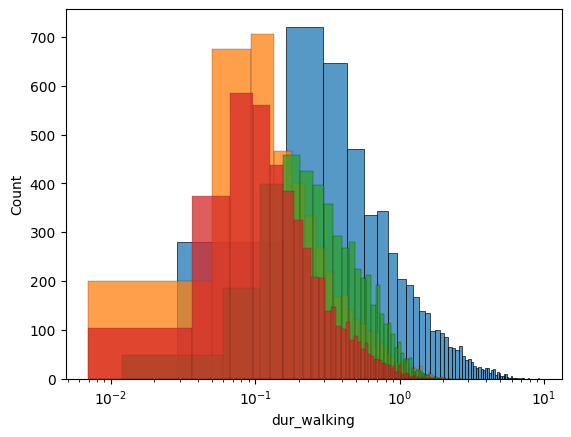

In [ ]:
df["dur_pt_access"] + df["dur_pt_rail"] + df["dur_pt_bus"] + df["dur_pt_int"]
sns.histplot(df["dur_walking"])
sns.histplot(df["dur_cycling"])
sns.histplot(df["dur_pt_access"] + df["dur_pt_rail"] + df["dur_pt_bus"] + df["dur_pt_int"])
sns.histplot(df["dur_driving"])
plt.xscale('log')
plt.show()

#### Piecewise Linear

In [146]:
thresholds = [0, 0.1, 0.5, 1, 2, None]

beta_time_1 = Beta('beta_time_0_0.1', 0, None, None, 0)
beta_time_2 = Beta('beta_time_0.1_0.5', 0, None, None, 0)
beta_time_3 = Beta('beta_time_0.5_1', 0, None, None, 0)
beta_time_4 = Beta('beta_time_1_2', 0, None, None, 0)
beta_time_5 = Beta('beta_time_2_more', 0, None, None, 0)
betas_piecewise = [beta_time_1, beta_time_2, beta_time_3, beta_time_4, beta_time_5]

In [148]:
piecewise_dur_walking = piecewise_formula(
    dur_walking, thresholds, betas_piecewise
)
piecewise_dur_cycling = piecewise_formula(
    dur_cycling, thresholds, betas_piecewise
)
dur_pt = Variable('dur_pt')
piecewise_dur_pt = piecewise_formula(
    dur_pt, thresholds, betas_piecewise
)
piecewise_dur_driving = piecewise_formula(
    dur_driving, thresholds, betas_piecewise
)

In [149]:
V_walk_3A_piecewise = (
    piecewise_dur_walking
)

V_cycle_3A_piecewise = (
    ASC_CYCLE_1A
    + beta_age_cycle * age
    + piecewise_dur_cycling
)

V_pt_3A_piecewise = (
    ASC_PT_1A
    + beta_age_pt * age
    + piecewise_dur_pt
    + B_COST_1A * cost_transit
)

V_car_3A_piecewise = (
    ASC_CAR_1A
    + beta_age_car * age
    + piecewise_dur_driving
    + B_COST_1A * cost_driving
)

V_3A_piecewise ={1: V_walk_3A_piecewise, 2: V_cycle_3A_piecewise, 3: V_pt_3A_piecewise, 4: V_car_3A_piecewise}
logprob_3A_piecewise = loglogit(V_3A_piecewise, None, travel_mode)
biogeme_3A_piecewise = bio.BIOGEME(database, logprob_3A_piecewise)
biogeme_3A_piecewise.modelName = 'model_3A_piecewise'

results_3A_piecewise = biogeme_3A_piecewise.estimate()
print(results_3A_piecewise.print_general_statistics())

Number of estimated parameters:	12
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4472.032
Final log likelihood:	-4472.032
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00268
Akaike Information Criterion:	8968.064
Bayesian Information Criterion:	9046.27
Final gradient norm:	6.5169E-01
Nbr of threads:	8



In [ ]:
# results_3A_piecewise.getEstimatedParameters()

In [150]:
piecewise_estimates = results_3A_piecewise.get_beta_values()
V_walk_3A_piecewise.fix_betas(beta_values=piecewise_estimates, prefix='piecewise_')
V_cycle_3A_piecewise.fix_betas(beta_values=piecewise_estimates, prefix='piecewise_')
V_pt_3A_piecewise.fix_betas(beta_values=piecewise_estimates, prefix='piecewise_')
V_car_3A_piecewise.fix_betas(beta_values=piecewise_estimates, prefix='piecewise_')

In [151]:
alpha = Beta('alpha', 0, None, None, 0)
Opt1 = (1 - alpha) * V_walk_2A + alpha * V_walk_3A_piecewise
Opt2 = (1 - alpha) * V_cycle_2A + alpha * V_cycle_3A_piecewise
Opt3 = (1 - alpha) * V_pt_2A + alpha * V_pt_3A_piecewise
Opt4 = (1 - alpha) * V_car_2A + alpha * V_car_3A_piecewise

V = {1: Opt1, 2: Opt2, 3: Opt3, 4: Opt4}
logprob = loglogit(V, None, travel_mode)
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_3A_composite'
results_composite = biogeme.estimate()


In [152]:
composite_parameters = results_composite.get_estimated_parameters()
display(composite_parameters)

,Value,Rob. Std err,Rob. t-test,Rob. p-value
B_TIME_CAR_1A,5.557848,10.275871,0.540864,0.588601
B_TIME_CYCLE_1A,7.591064,11.031446,0.688129,0.491371
B_TIME_PT_1A,9.926477,11.333093,0.875884,0.381093
B_TIME_WALK_1A,-13.811273,4.804501,-2.874653,0.004045
alpha,0.945865,0.033619,28.134685,0.000000


In [153]:
t_test_alpha = composite_parameters.loc['alpha', 'Rob. t-test']
print(f't-test for alpha: {t_test_alpha:.3g}')

t-test for alpha: 28.1


In [154]:
p_value_alpha = composite_parameters.loc['alpha', 'Rob. p-value']
print(f'p-value for alpha: {p_value_alpha:.3g}')


p-value for alpha: 0


Under the null hypothesis, the true value of $\alpha$ is 0. This hypothesis can be safely rejected here. Therefore, the piecewise linear specification is preferred.

#### Box-Cox

In [ ]:
lambda_boxcox_walking = Beta('lambda_boxcox_walking', 1, -10, 10, 0)
boxcox_dur_walking_unrestricted = boxcox(dur_walking, lambda_boxcox_walking)

lambda_boxcox_cycling = Beta('lambda_boxcox_cycling', 1, -10, 10, 0)
boxcox_dur_cycling_unrestricted = boxcox(dur_cycling, lambda_boxcox_cycling)

lambda_boxcox_pt = Beta('lambda_boxcox_pt', 1, -10, 10, 0)
boxcox_dur_pt_unrestricted = boxcox(dur_pt, lambda_boxcox_pt)

lambda_boxcox_driving = Beta('lambda_boxcox_driving', 1, -10, 10, 0)
boxcox_dur_driving_unrestricted = boxcox(dur_driving, lambda_boxcox_driving)

In [ ]:
V_walk_3B_unrestricted = (
    B_TIME_WALK_1A * boxcox_dur_walking_unrestricted
)

V_cycle_3B_unrestricted = (
    ASC_CYCLE_1A
    + beta_age_cycle * age
    + B_TIME_CYCLE_1A * boxcox_dur_cycling_unrestricted
)

V_pt_3B_unrestricted = (
    ASC_PT_1A
    + beta_age_pt * age
    + B_TIME_PT_1A * boxcox_dur_pt_unrestricted
    + B_COST_1A * cost_transit
)

V_car_3B_unrestricted = (
    ASC_CAR_1A
    + beta_age_car * age
    + B_TIME_CAR_1A * boxcox_dur_driving_unrestricted
    + B_COST_1A * cost_driving
)

V_3B_unrestricted ={1: V_walk_3B_unrestricted, 2: V_cycle_3B_unrestricted, 3: V_pt_3B_unrestricted, 4: V_car_3B_unrestricted}
logprob_3B_unrestricted = loglogit(V_3B_unrestricted, None, travel_mode)
biogeme_3B_unrestricted = bio.BIOGEME(database, logprob_3B_unrestricted)
biogeme_3B_unrestricted.modelName = 'model_3B_unrestricted'

results_3B_unrestricted = biogeme_3B_unrestricted.estimate()
print(results_3B_unrestricted.print_general_statistics())

In [ ]:
results_3B_unrestricted.getEstimatedParameters()

In [ ]:
lr_result3B = results_3B_unrestricted.likelihood_ratio_test(results_2A, 0.05)
print(f'{lr_result3B.statistic=:.3g}')
print(f'{lr_result3B.threshold=:.3g}')
print(lr_result3B.message)

In [ ]:
lambda_boxcox = Beta('lambda_boxcox', 1, -10, 10, 0)
boxcox_dur_walking = boxcox(dur_walking, lambda_boxcox)
boxcox_dur_cycling = boxcox(dur_cycling, lambda_boxcox)
boxcox_dur_pt = boxcox(dur_pt, lambda_boxcox)
boxcox_dur_driving = boxcox(dur_driving, lambda_boxcox)

In [ ]:
V_walk_3B_restricted = (
    B_TIME_WALK_1A * boxcox_dur_walking
)

V_cycle_3B_restricted = (
    ASC_CYCLE_1A
    + beta_age_cycle * age
    + B_TIME_CYCLE_1A * boxcox_dur_cycling
)

V_pt_3B_restricted = (
    ASC_PT_1A
    + beta_age_pt * age
    + B_TIME_PT_1A * boxcox_dur_pt
    + B_COST_1A * cost_transit
)

V_car_3B_restricted = (
    ASC_CAR_1A
    + beta_age_car * age
    + B_TIME_CAR_1A * boxcox_dur_driving
    + B_COST_1A * cost_driving
)

V_3B_restricted ={1: V_walk_3B_restricted, 2: V_cycle_3B_restricted, 3: V_pt_3B_restricted, 4: V_car_3B_restricted}
logprob_3B_restricted = loglogit(V_3B_restricted, None, travel_mode)
biogeme_3B_restricted = bio.BIOGEME(database, logprob_3B_restricted)
biogeme_3B_restricted.modelName = 'model_3B_restricted'

results_3B_restricted = biogeme_3B_restricted.estimate()
print(results_3B_restricted.print_general_statistics())

In [ ]:
results_3B_restricted.getEstimatedParameters()

In [ ]:
lr_result3B = results_3B_restricted.likelihood_ratio_test(results_2A, 0.05)
print(f'{lr_result3B.statistic=:.3g}')
print(f'{lr_result3B.threshold=:.3g}')
print(lr_result3B.message)

Testing the unrestricted model where each utility has its own lambda, with the restriction of all lambdas equal.

In [ ]:
lr_result3B = results_3B_unrestricted.likelihood_ratio_test(results_3B_restricted, 0.05)
print(f'{lr_result3B.statistic=:.3g}')
print(f'{lr_result3B.threshold=:.3g}')
print(lr_result3B.message)

#### Power series

Trying square

In [164]:
B_TIME_WALK_3C_squared  = Beta('B_TIME_WALK_3C_squared', 0, None, None, 0)
B_TIME_CYCLE_3C_squared = Beta('B_TIME_CYCLE_3C_squared', 0, None, None, 0)
B_TIME_PT_3C_squared    = Beta('B_TIME_PT_3C_squared', 0, None, None, 0)
B_TIME_CAR_3C_squared   = Beta('B_TIME_CAR_3C_squared', 0, None, None, 0)

In [165]:
V_walk_3C_piecewise_squared = (
    B_TIME_WALK_1A * dur_walking
    + B_TIME_WALK_3C_squared * dur_walking * dur_walking
)

V_cycle_3C_piecewise_squared = (
    ASC_CYCLE_1A
    + beta_age_cycle * age
    + B_TIME_CYCLE_1A * dur_cycling
    + B_TIME_CYCLE_3C_squared * dur_cycling * dur_cycling
)

V_pt_3C_piecewise_squared = (
    ASC_PT_1A
    + beta_age_pt * age
    + B_TIME_PT_1A * dur_pt
    + B_TIME_PT_3C_squared * dur_pt * dur_pt
    + B_COST_1A * cost_transit
)

V_car_3C_piecewise_squared = (
    ASC_CAR_1A
    + beta_age_car * age
    + B_TIME_CAR_1A * dur_driving
    + B_TIME_CAR_3C_squared * dur_driving * dur_driving
    + B_COST_1A * cost_driving
)

V_3C_piecewise_squared ={1: V_walk_3C_piecewise_squared, 2: V_cycle_3C_piecewise_squared, 3: V_pt_3C_piecewise_squared, 4: V_car_3C_piecewise_squared}
logprob_3C_piecewise_squared = loglogit(V_3C_piecewise_squared, None, travel_mode)
biogeme_3C_piecewise_squared = bio.BIOGEME(database, logprob_3C_piecewise_squared)
biogeme_3C_piecewise_squared.modelName = 'model_3C_power_series_2'

results_3C_piecewise_squared = biogeme_3C_piecewise_squared.estimate()
print(results_3C_piecewise_squared.print_general_statistics())

Number of estimated parameters:	8
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4697.361
Final log likelihood:	-4422.424
Likelihood ratio test for the init. model:	549.8749
Rho-square for the init. model:	0.0585
Rho-square-bar for the init. model:	0.0568
Akaike Information Criterion:	8860.847
Bayesian Information Criterion:	8912.985
Final gradient norm:	6.2582E-02
Nbr of threads:	8



Trying cubed

In [161]:
B_TIME_WALK_3C_cubed  = Beta('B_TIME_WALK_3C_cubed', 0, None, None, 0)
B_TIME_CYCLE_3C_cubed = Beta('B_TIME_CYCLE_3C_cubed', 0, None, None, 0)
B_TIME_PT_3C_cubed    = Beta('B_TIME_PT_3C_cubed', 0, None, None, 0)
B_TIME_CAR_3C_cubed   = Beta('B_TIME_CAR_3C_cubed', 0, None, None, 0)

In [162]:
V_walk_3C_piecewise_cubed = (
    B_TIME_WALK_1A * dur_walking
    + B_TIME_WALK_3C_cubed * dur_walking * dur_walking * dur_walking
)

V_cycle_3C_piecewise_cubed = (
    ASC_CYCLE_1A
    + beta_age_cycle * age
    + B_TIME_CYCLE_1A * dur_cycling
    + B_TIME_CYCLE_3C_cubed * dur_cycling * dur_cycling * dur_cycling
)

V_pt_3C_piecewise_cubed = (
    ASC_PT_1A
    + beta_age_pt * age
    + B_TIME_PT_1A * dur_pt
    + B_TIME_PT_3C_cubed * dur_pt * dur_pt * dur_pt
    + B_COST_1A * cost_transit
)

V_car_3C_piecewise_cubed = (
    ASC_CAR_1A
    + beta_age_car * age
    + B_TIME_CAR_1A * dur_driving
    + B_TIME_CAR_3C_cubed * dur_driving * dur_driving * dur_driving
    + B_COST_1A * cost_driving
)

V_3C_piecewise_cubed ={1: V_walk_3C_piecewise_cubed, 2: V_cycle_3C_piecewise_cubed, 3: V_pt_3C_piecewise_cubed, 4: V_car_3C_piecewise_cubed}
logprob_3C_piecewise_cubed = loglogit(V_3C_piecewise_cubed, None, travel_mode)
biogeme_3C_piecewise_cubed = bio.BIOGEME(database, logprob_3C_piecewise_cubed)
biogeme_3C_piecewise_cubed.modelName = 'model_3C_power_series_3'

results_3C_piecewise_cubed = biogeme_3C_piecewise_cubed.estimate()
print(results_3C_piecewise_cubed.print_general_statistics())

Number of estimated parameters:	8
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-5073.632
Final log likelihood:	-4503.207
Likelihood ratio test for the init. model:	1140.85
Rho-square for the init. model:	0.112
Rho-square-bar for the init. model:	0.111
Akaike Information Criterion:	9022.413
Bayesian Information Criterion:	9074.551
Final gradient norm:	4.4481E-02
Nbr of threads:	8



## Model 4